# Homework

In [1]:
import numpy as np
import pandas as pd
from matplotlib import patheffects
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
from branca.colormap import linear

## Preprocessing

Прежде всего загрузим данные и выведем информацию о содержимом:

In [2]:
airlines_df = pd.read_csv('airlines.csv', low_memory=False)
airports_df = pd.read_csv('airports.csv', low_memory=False)
flights_df = pd.read_csv('flights.csv', low_memory=False)

In [3]:
airlines_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 356.0+ bytes


In [4]:
airports_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [5]:
flights_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

Как мы видим, с *airlines* всё в порядке. В *airports* присутствуют 3 аэропорта, у которых отстутствуют координаты (будем считать их некорректными, а значит удаляем).

In [6]:
airports_df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

А вот *flights* требует более тщательного рассмотрения.

In [7]:
flights_df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

Многие пропуски могут быть связаны с отменой рейса, поэтому здесь стоит отделить отменённые рейсы от остальных.

In [8]:
cancelled_flights_df = flights_df[flights_df['CANCELLED'] == 1]

flights_df['CANCELLED'].fillna(0, inplace=True) # Если пропущено, то считаем, что не был отменён
flights_df = flights_df[flights_df['CANCELLED'] == 0]

In [9]:
cancelled_flights_df.isna().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER            14721
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME         86153
DEPARTURE_DELAY        86153
TAXI_OUT               89047
WHEELS_OFF             89047
SCHEDULED_TIME             5
ELAPSED_TIME           89884
AIR_TIME               89884
DISTANCE                   0
WHEELS_ON              89884
TAXI_IN                89884
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME           89884
ARRIVAL_DELAY          89884
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON        0
AIR_SYSTEM_DELAY       89884
SECURITY_DELAY         89884
AIRLINE_DELAY          89884
LATE_AIRCRAFT_DELAY    89884
WEATHER_DELAY          89884
dtype: int64

In [10]:
flights_df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER                  0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               1
ELAPSED_TIME             15187
AIR_TIME                 15187
DISTANCE                     0
WHEELS_ON                 2629
TAXI_IN                   2629
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME              2629
ARRIVAL_DELAY            15187
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4665756
SECURITY_DELAY         4665756
AIRLINE_DELAY          4665756
LATE_AIRCRAFT_DELAY    4665756
WEATHER_DELAY          4665756
dtype: int64

К тому же не лишним будет отделить от основных те рейсы, которые были перенаправлены.

In [11]:
diverted_flights_df = flights_df[flights_df['DIVERTED'] == 1]

flights_df = flights_df[flights_df['DIVERTED'] == 0]

In [12]:
diverted_flights_df.isna().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER                0
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME             0
DEPARTURE_DELAY            0
TAXI_OUT                   0
WHEELS_OFF                 0
SCHEDULED_TIME             1
ELAPSED_TIME           15187
AIR_TIME               15187
DISTANCE                   0
WHEELS_ON               2629
TAXI_IN                 2629
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME            2629
ARRIVAL_DELAY          15187
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON    15187
AIR_SYSTEM_DELAY       15187
SECURITY_DELAY         15187
AIRLINE_DELAY          15187
LATE_AIRCRAFT_DELAY    15187
WEATHER_DELAY          15187
dtype: int64

In [13]:
flights_df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER                  0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               0
ELAPSED_TIME                 0
AIR_TIME                     0
DISTANCE                     0
WHEELS_ON                    0
TAXI_IN                      0
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME                 0
ARRIVAL_DELAY                0
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5714008
AIR_SYSTEM_DELAY       4650569
SECURITY_DELAY         4650569
AIRLINE_DELAY          4650569
LATE_AIRCRAFT_DELAY    4650569
WEATHER_DELAY          4650569
dtype: int64

Теперь наши рейсы разбиты на 3 **непересекающихся** класса: *"хорошие"* `flights_df`, *отменённые* `cancelled_flights_df` и *перенаправленные* `diverted_flights_df`.

In [14]:
flights_df.describe().T

count         mean          std     min     25%  \
YEAR                 5714008.0  2015.000000     0.000000  2015.0  2015.0   
MONTH                5714008.0     6.547799     3.397421     1.0     4.0   
DAY                  5714008.0    15.707591     8.774394     1.0     8.0   
DAY_OF_WEEK          5714008.0     3.932643     1.985967     1.0     2.0   
FLIGHT_NUMBER        5714008.0  2164.383547  1754.706022     1.0   728.0   
SCHEDULED_DEPARTURE  5714008.0  1328.907421   483.525058     1.0   916.0   
DEPARTURE_TIME       5714008.0  1335.065627   496.419817     1.0   921.0   
DEPARTURE_DELAY      5714008.0     9.294842    36.889724   -82.0    -5.0   
TAXI_OUT             5714008.0    16.065498     8.882449     1.0    11.0   
WHEELS_OFF           5714008.0  1357.099048   498.023745     1.0   935.0   
SCHEDULED_TIME       5714008.0   141.893974    75.313998    18.0    85.0   
ELAPSED_TIME         5714008.0   137.006189    74.211072    14.0    82.0   
AIR_TIME             5714008.0   113.511628    72.230822     7.0    60.0   
DISTANCE             5714008.0   824.456903   608.661990    31.0   373.0   
WHEELS_ON            5714008.0  1471.319332   521.868240     1.0  1054.0   
TAXI_IN              5714008.0     7.429063     5.618951     1.0     4.0   
SCHEDULED_ARRIVAL    5714008.0  1493.186814   506.901121     1.0  1110.0   
ARRIVAL_TIME         5714008.0  1476.373460   525.973017     1.0  1058.0   
ARRIVAL_DELAY        5714008.0     4.407057    39.271297   -87.0   -13.0   
DIVERTED             5714008.0     0.000000     0.000000     0.0     0.0   
CANCELLED            5714008.0     0.000000     0.000000     0.0     0.0   
AIR_SYSTEM_DELAY     1063439.0    13.480568    28.003679     0.0     0.0   
SECURITY_DELAY       1063439.0     0.076154     2.143460     0.0     0.0   
AIRLINE_DELAY        1063439.0    18.969547    48.161642     0.0     0.0   
LATE_AIRCRAFT_DELAY  1063439.0    23.472838    43.197018     0.0     0.0   
WEATHER_DELAY        1063439.0     2.915290    20.433336     0.0     0.0   

                        50%     75%     max  
YEAR                 2015.0  2015.0  2015.0  
MONTH                   7.0     9.0    12.0  
DAY                    16.0    23.0    31.0  
DAY_OF_WEEK             4.0     6.0     7.0  
FLIGHT_NUMBER        1681.0  3211.0  9320.0  
SCHEDULED_DEPARTURE  1325.0  1730.0  2359.0  
DEPARTURE_TIME       1330.0  1740.0  2400.0  
DEPARTURE_DELAY        -2.0     7.0  1988.0  
TAXI_OUT               14.0    19.0   225.0  
WHEELS_OFF           1343.0  1754.0  2400.0  
SCHEDULED_TIME        123.0   174.0   718.0  
ELAPSED_TIME          118.0   168.0   766.0  
AIR_TIME               94.0   144.0   690.0  
DISTANCE              650.0  1065.0  4983.0  
WHEELS_ON            1508.0  1911.0  2400.0  
TAXI_IN                 6.0     9.0   248.0  
SCHEDULED_ARRIVAL    1520.0  1917.0  2400.0  
ARRIVAL_TIME         1512.0  1916.0  2400.0  
ARRIVAL_DELAY          -5.0     8.0  1971.0  
DIVERTED                0.0     0.0     0.0  
CANCELLED               0.0     0.0     0.0  
AIR_SYSTEM_DELAY        2.0    18.0  1134.0  
SECURITY_DELAY          0.0     0.0   573.0  
AIRLINE_DELAY           2.0    19.0  1971.0  
LATE_AIRCRAFT_DELAY     3.0    29.0  1331.0  
WEATHER_DELAY           0.0     0.0  1211.0

Мы видим, что *DEPARTURE_DELAY* может принимать отрицательные значения, т.е. является в точности разницей между *SCHEDULED_DEPARTURE* и *DEPARTURE_TIME*, что не очень то нам и подходит, т.к. по сути это не является задержкой вылета. Для этого все отрицательные значения задержки вылета заменим на $0$.

In [15]:
flights_df['DEPARTURE_DELAY'] = flights_df['DEPARTURE_DELAY'].apply(lambda x: max(x, 0))

Теперь разделим `flights_df` на те, у которых всё хорошо, т.е. *DEPARTURE_DELAY* $= 0$, и на те, которые вылетели с задержкой.

In [16]:
flights_without_delay_df = flights_df[flights_df['DEPARTURE_DELAY'] == 0]

flights_with_delay_df = flights_df[flights_df['DEPARTURE_DELAY'] > 0]

## Analysis

### Анализ задержек вылета в течение дня/недели/месяца/года

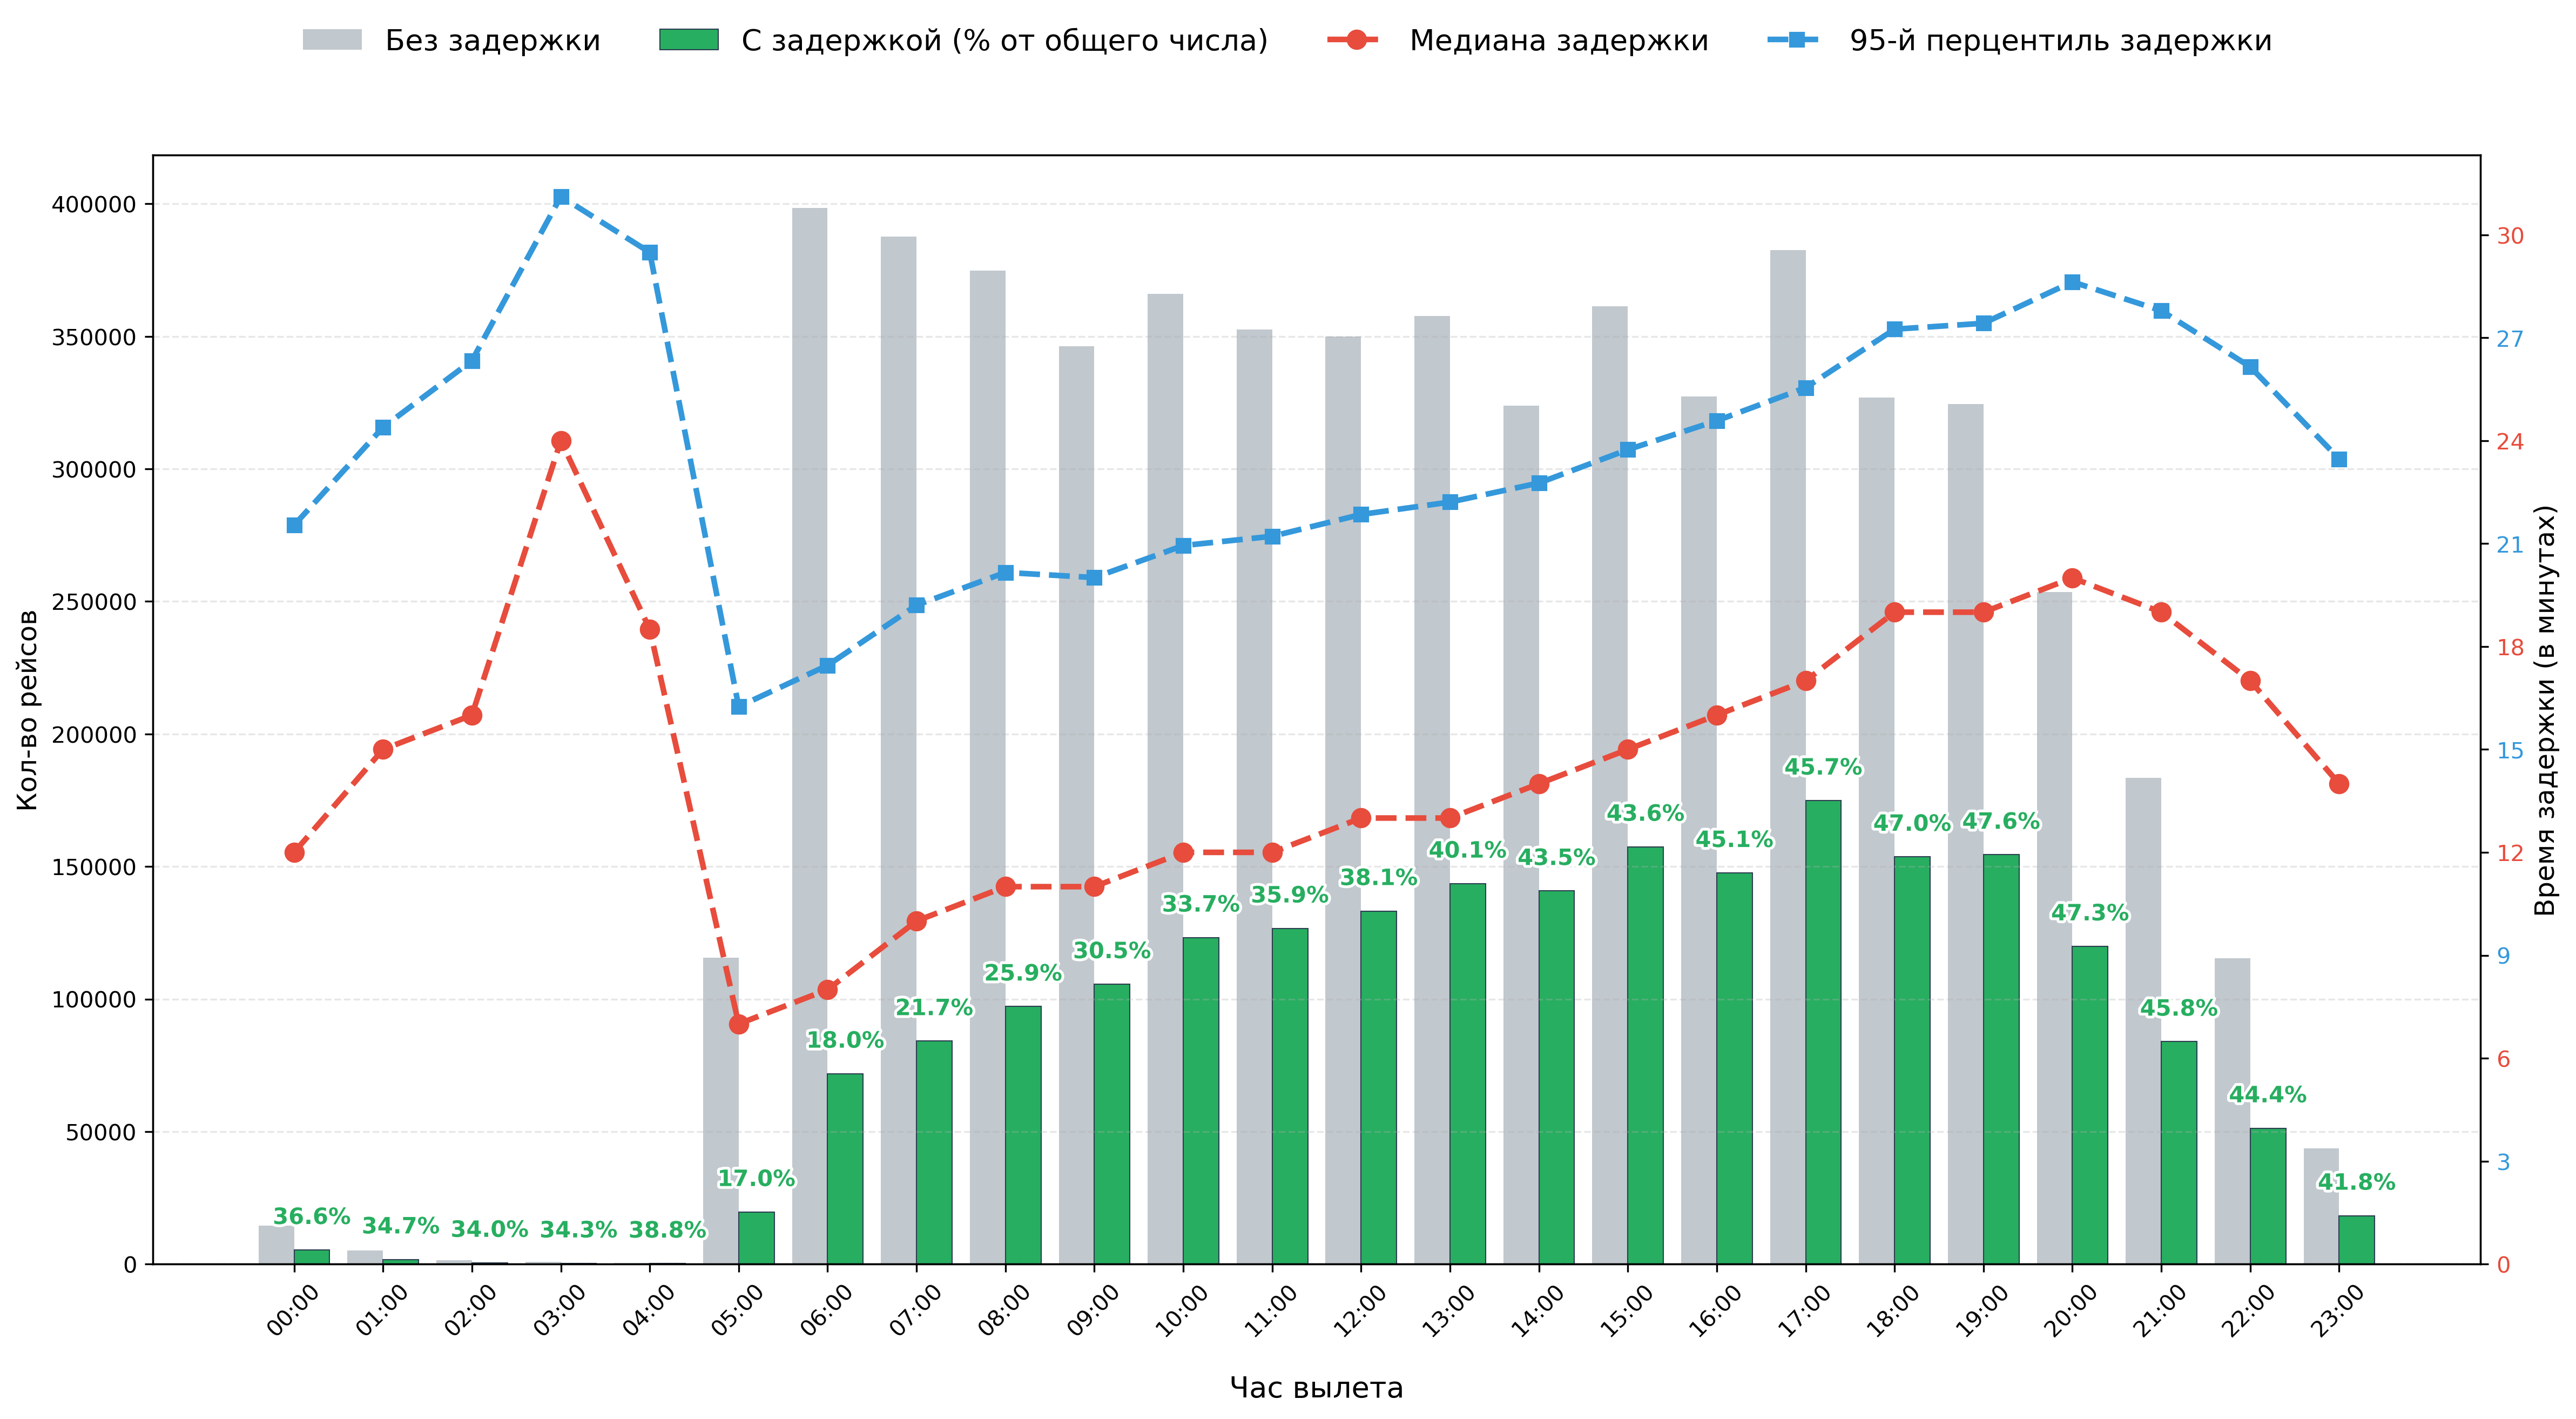

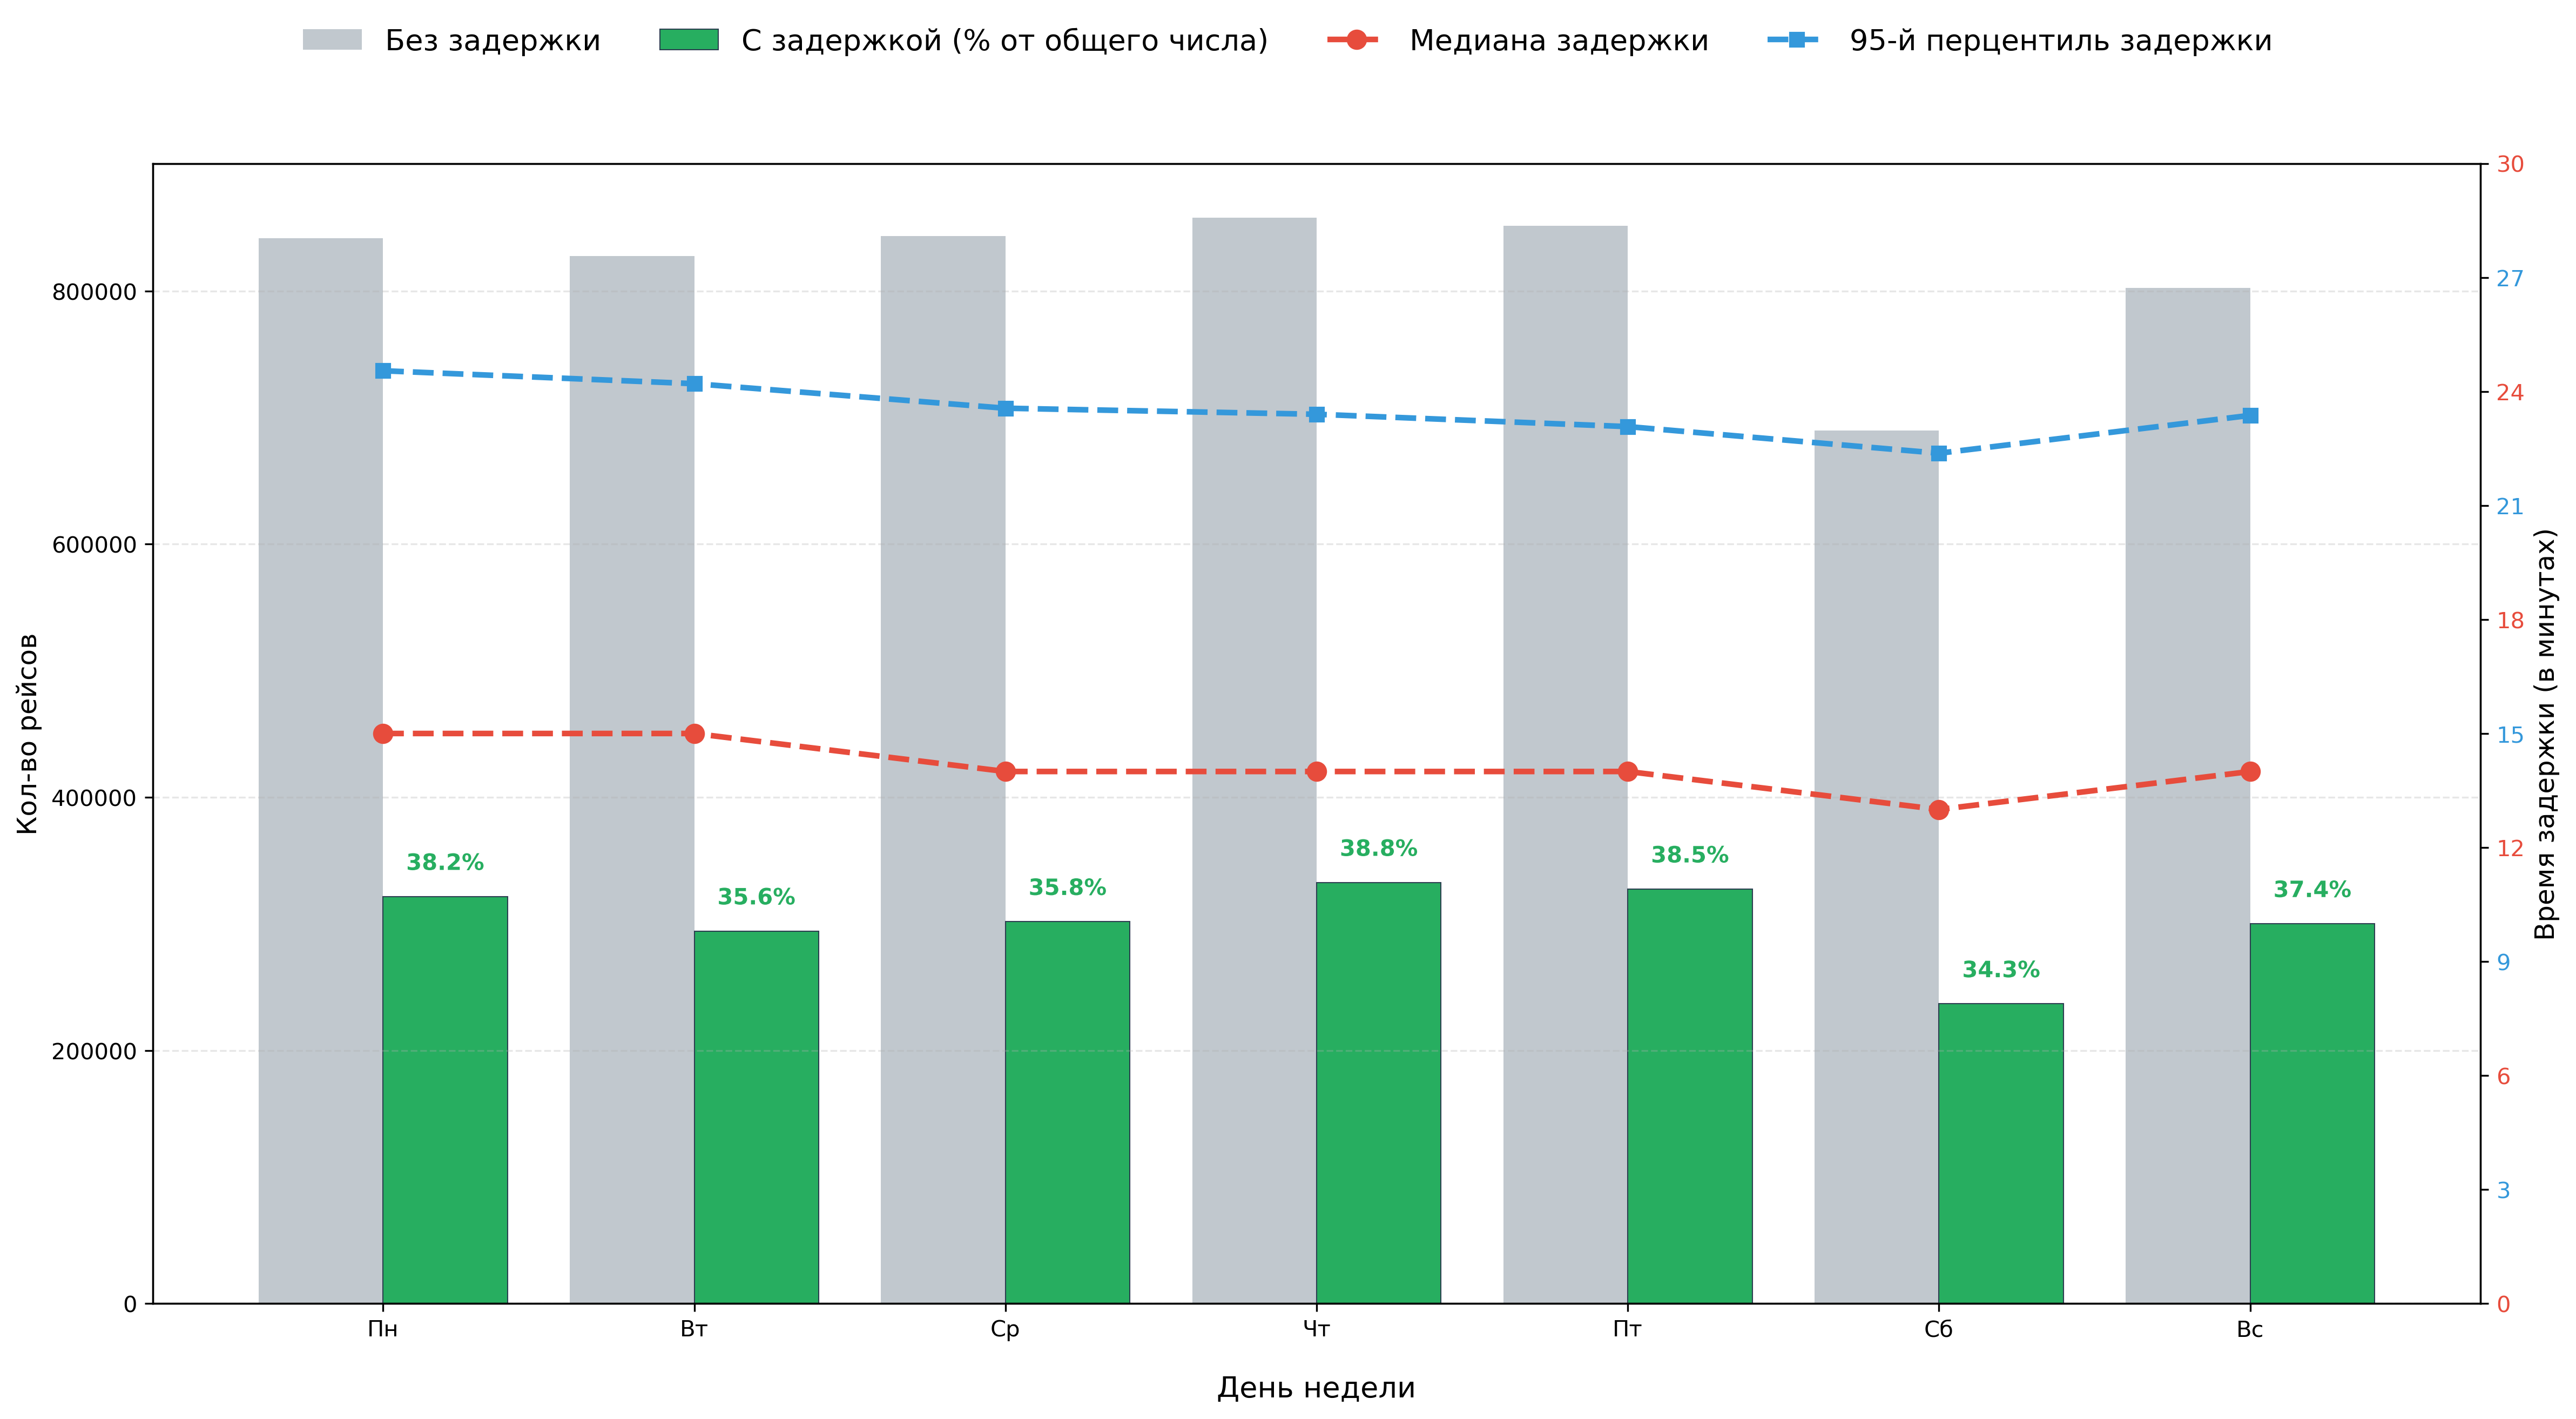

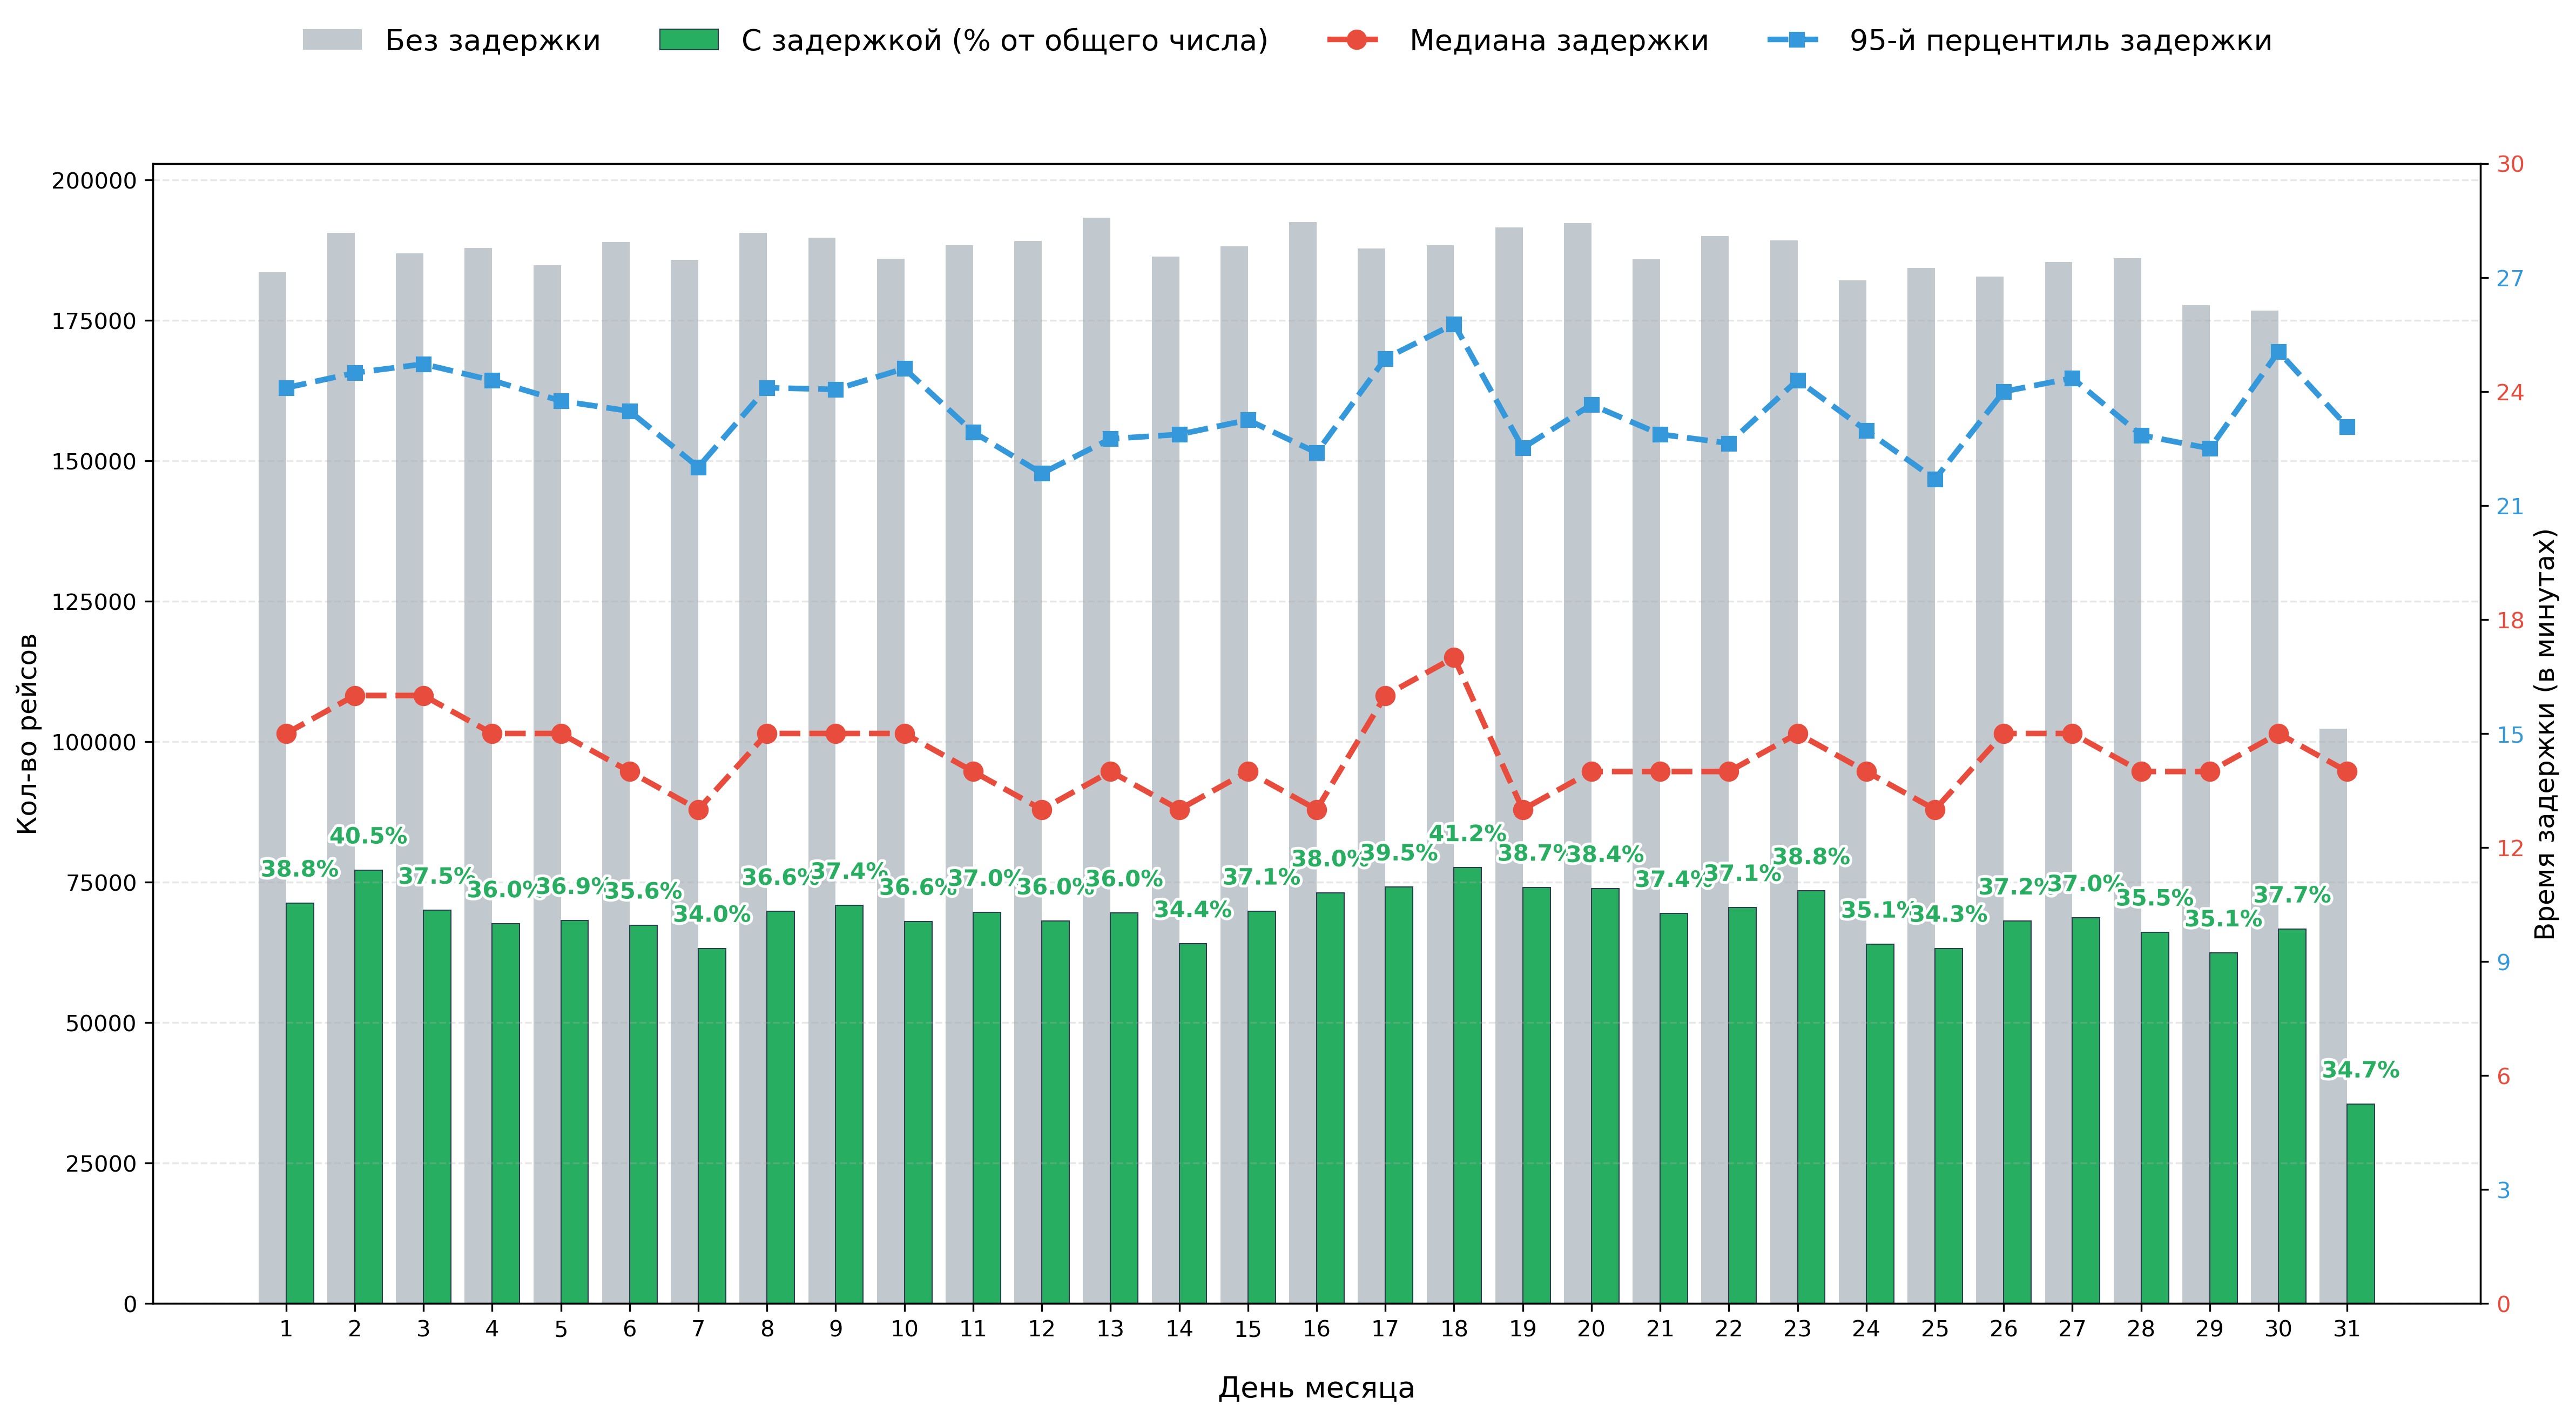

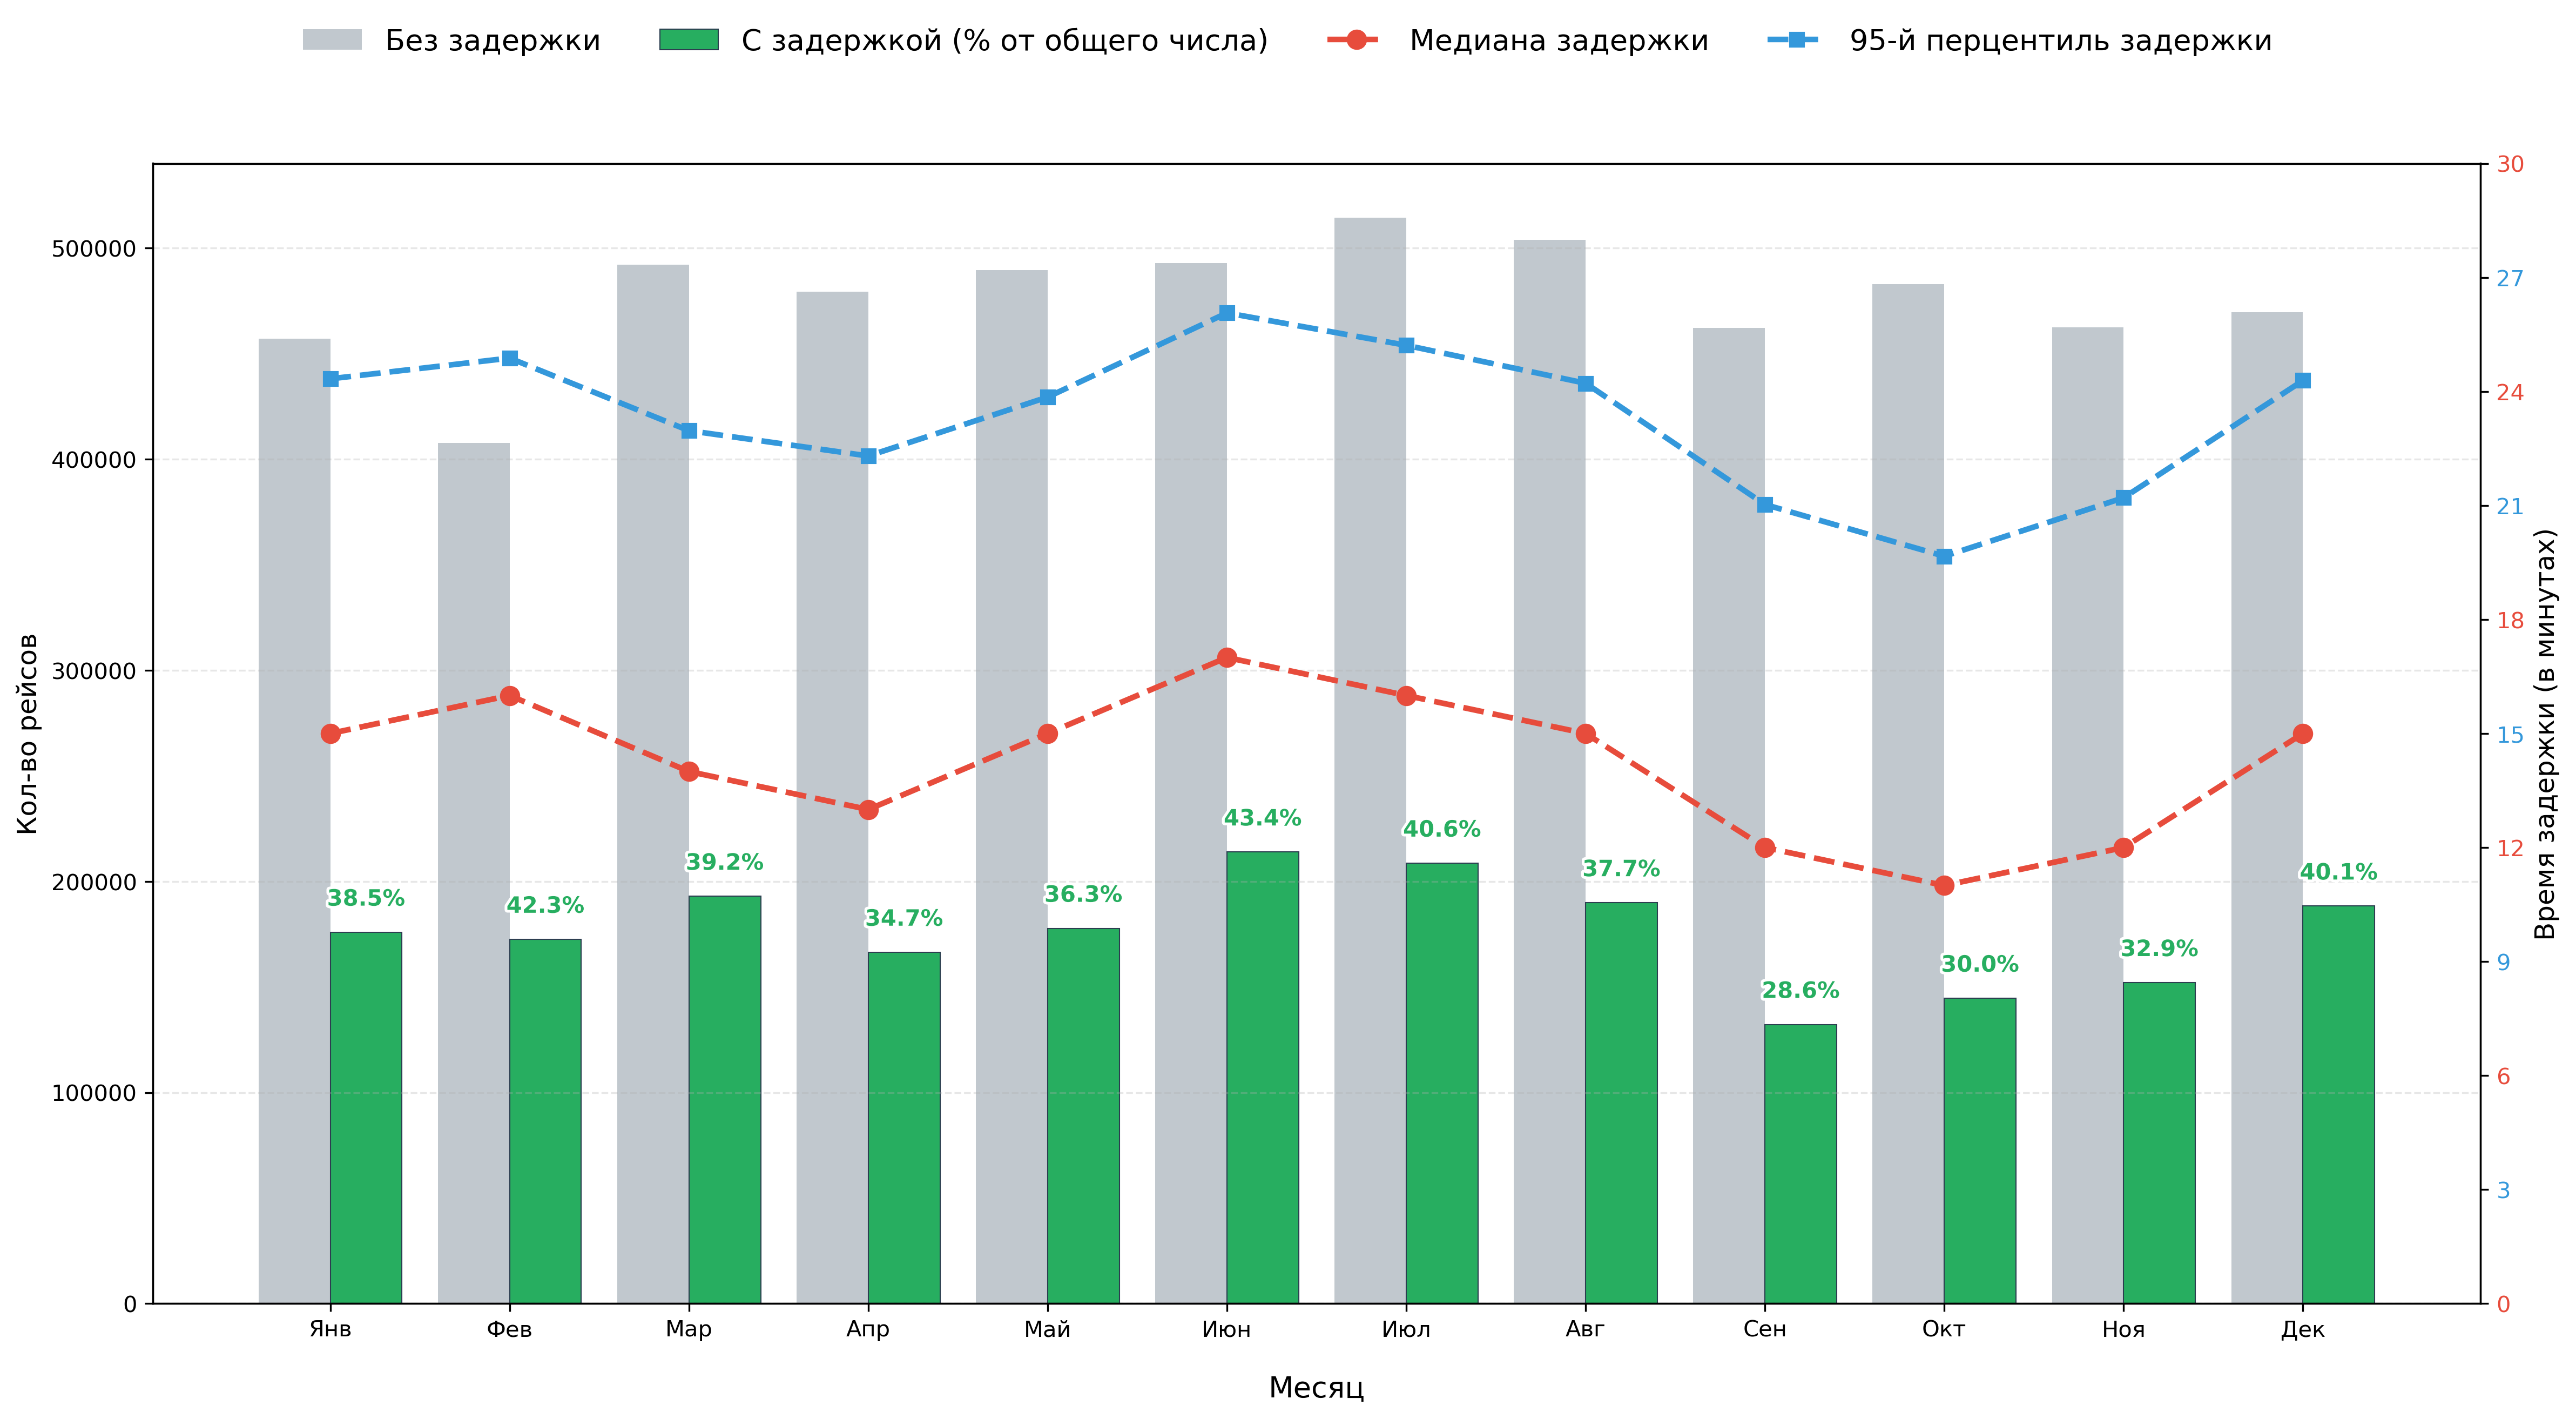

In [17]:
df = flights_with_delay_df.copy()
all_df = flights_df.copy()

groupings = [
    ('SCHEDULED_DEPARTURE', 'hour'),
    ('DAY_OF_WEEK', 'week'),
    ('DAY', 'month_day'),
    ('MONTH', 'year_month')
]

weekday_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
month_labels = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

for grouping, period in groupings:
    if period == 'hour':
        df[grouping] = df[grouping].floordiv(100)
        all_df[grouping] = all_df[grouping].floordiv(100)

        full_index = pd.Index(range(0, 24), name=grouping)
        xlabel = "Час вылета"
        fmt = lambda x: f"{x:02}:00"

    elif period == 'week':
        full_index = pd.Index(range(1, 8), name=grouping)
        xlabel = "День недели"
        fmt = lambda x: weekday_labels[x-1]

    elif period == 'month_day':
        full_index = pd.Index(range(1, 32), name=grouping)
        xlabel = "День месяца"
        fmt = lambda x: str(x)

    elif period == 'year_month':
        full_index = pd.Index(range(1, 13), name=grouping)
        xlabel = "Месяц"
        fmt = lambda x: month_labels[x-1]
    
    total_flights_by = all_df.groupby(grouping)['DEPARTURE_DELAY'].agg(['count']).reindex(full_index)
    delay_by = df.groupby(grouping)['DEPARTURE_DELAY'].agg(['count', 'median']).reindex(full_index)

    delay_by['mean_no_outliers'] = (
        df[df['DEPARTURE_DELAY'] <= df['DEPARTURE_DELAY'].quantile(0.95)]
        .groupby(grouping)['DEPARTURE_DELAY']
        .mean()
        .reindex(total_flights_by.index)
    )

    delay_by['percent'] = (delay_by['count'] / total_flights_by['count'] * 100).round(1)

    fig, ax1 = plt.subplots(figsize=(16, 8), dpi=300)
    x_pos = np.arange(len(full_index))
    width = 0.4

    ax1.bar(
        x_pos - width/2,
        total_flights_by['count'],
        width,
        color='#34495e',
        alpha=0.3,
        label='Без задержки'
    )

    bars = ax1.bar(
        x_pos + width/2,
        delay_by['count'],
        width,
        color='#27ae60',
        edgecolor='#2c3e50',
        linewidth=0.5,
        label='С задержкой (% от общего числа)'
    )

    for bar, pct in zip(bars, delay_by['percent']):
        ax1.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + total_flights_by['count'].max()*0.02,
            f'{pct}%' if pct != 0 else '',
            ha='center',
            va='bottom',
            color='#27ae60',
            fontsize=10,
            fontweight='bold',
            path_effects=[
                patheffects.withStroke(
                    linewidth=2.5,
                    foreground='white'
                )
            ]
        )

    ax2 = ax1.twinx()
    ax2.plot(
        x_pos,
        delay_by['median'],
        color='#e74c3c',
        marker='o',
        markersize=8,
        linewidth=2.5,
        linestyle='--',
        label='Медиана задержки'
    )
    ax2.plot(
        x_pos,
        delay_by['mean_no_outliers'],
        color='#3498db',
        marker='s',
        markersize=6,
        linewidth=2.5,
        linestyle='--',
        label='95-й перцентиль задержки'
    )

    ax1.set_xticks(x_pos)
    ax2.set_yticks(np.arange(0, 33, 3))

    labels = ax2.get_yticklabels()
    for idx, label in enumerate(labels):
        if idx % 2 == 0:
            label.set_color('#e74c3c')
        else:
            label.set_color('#3498db')

    ax1.set_xticklabels([fmt(x) for x in full_index], rotation=45 if period == 'hour' else 0)
    ax1.set_xlabel(xlabel, fontsize=13, labelpad=15)
    ax1.set_ylabel('Кол-во рейсов', fontsize=12)
    ax2.set_ylabel('Время задержки (в минутах)', fontsize=12)
    
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    handles = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
    labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
    fig.legend(
        handles, labels,
        loc='upper center',
        ncol=4,
        bbox_to_anchor=(0.5, 1.1),
        frameon=False,
        fontsize=13
    )
    
    plt.tight_layout()
    plt.show()

Отсюда можно сделать такие **выводы**:
 * Пиковое кол-во рейсов в течение дня приходится на утро с 6:00 до 7:00, но при этом процент рейсов с задержкой вылета небольшой. В течение дня общее число рейсов незначительно падает, а вот кол-во рейсов с задержкой вылета постоянно растёт, как и время этих задержек. Это может быть связано с тем, что каждая задержка порождает цепочку задержек, что в свою очередь означает недостаток инфраструктуры, чтобы справляться с высокими нагрузками в течение дня.
 * В течение недели процент рейсов с задержкой вылета от общего числа вполне стабилен. Хотя можно отметить то, что общее число рейсов на выходных в среднем меньше, чем в другие дни недели, и при этом процент рейсов с задержкой в *Сб* наименьший. Можно было бы попробовать перенести некоторые рейсы на *Сб*, чтобы уменьшить нагрузку в другие дни, например, перенести некоторое кол-во рейсов с *Пт* на *Сб*.
 * Наибольший процент рейсов с задержкой в течение года наблюдается в начале лета, а наименьший в начале осени. Если же это может быть связано опять же с большим трафиком в летнее время, что как раз видно по общему кол-ву рейсов, то рост процента рейсов с задержкой в зимнее время может быть связан с погодными условиями. Рекомендуется обеспечить аэропорты необходимым оборудованием, например, снегоуборочными машинами (там, где есть снег, конечно же).

### Анализ задержек вылета по авиакомпаниям

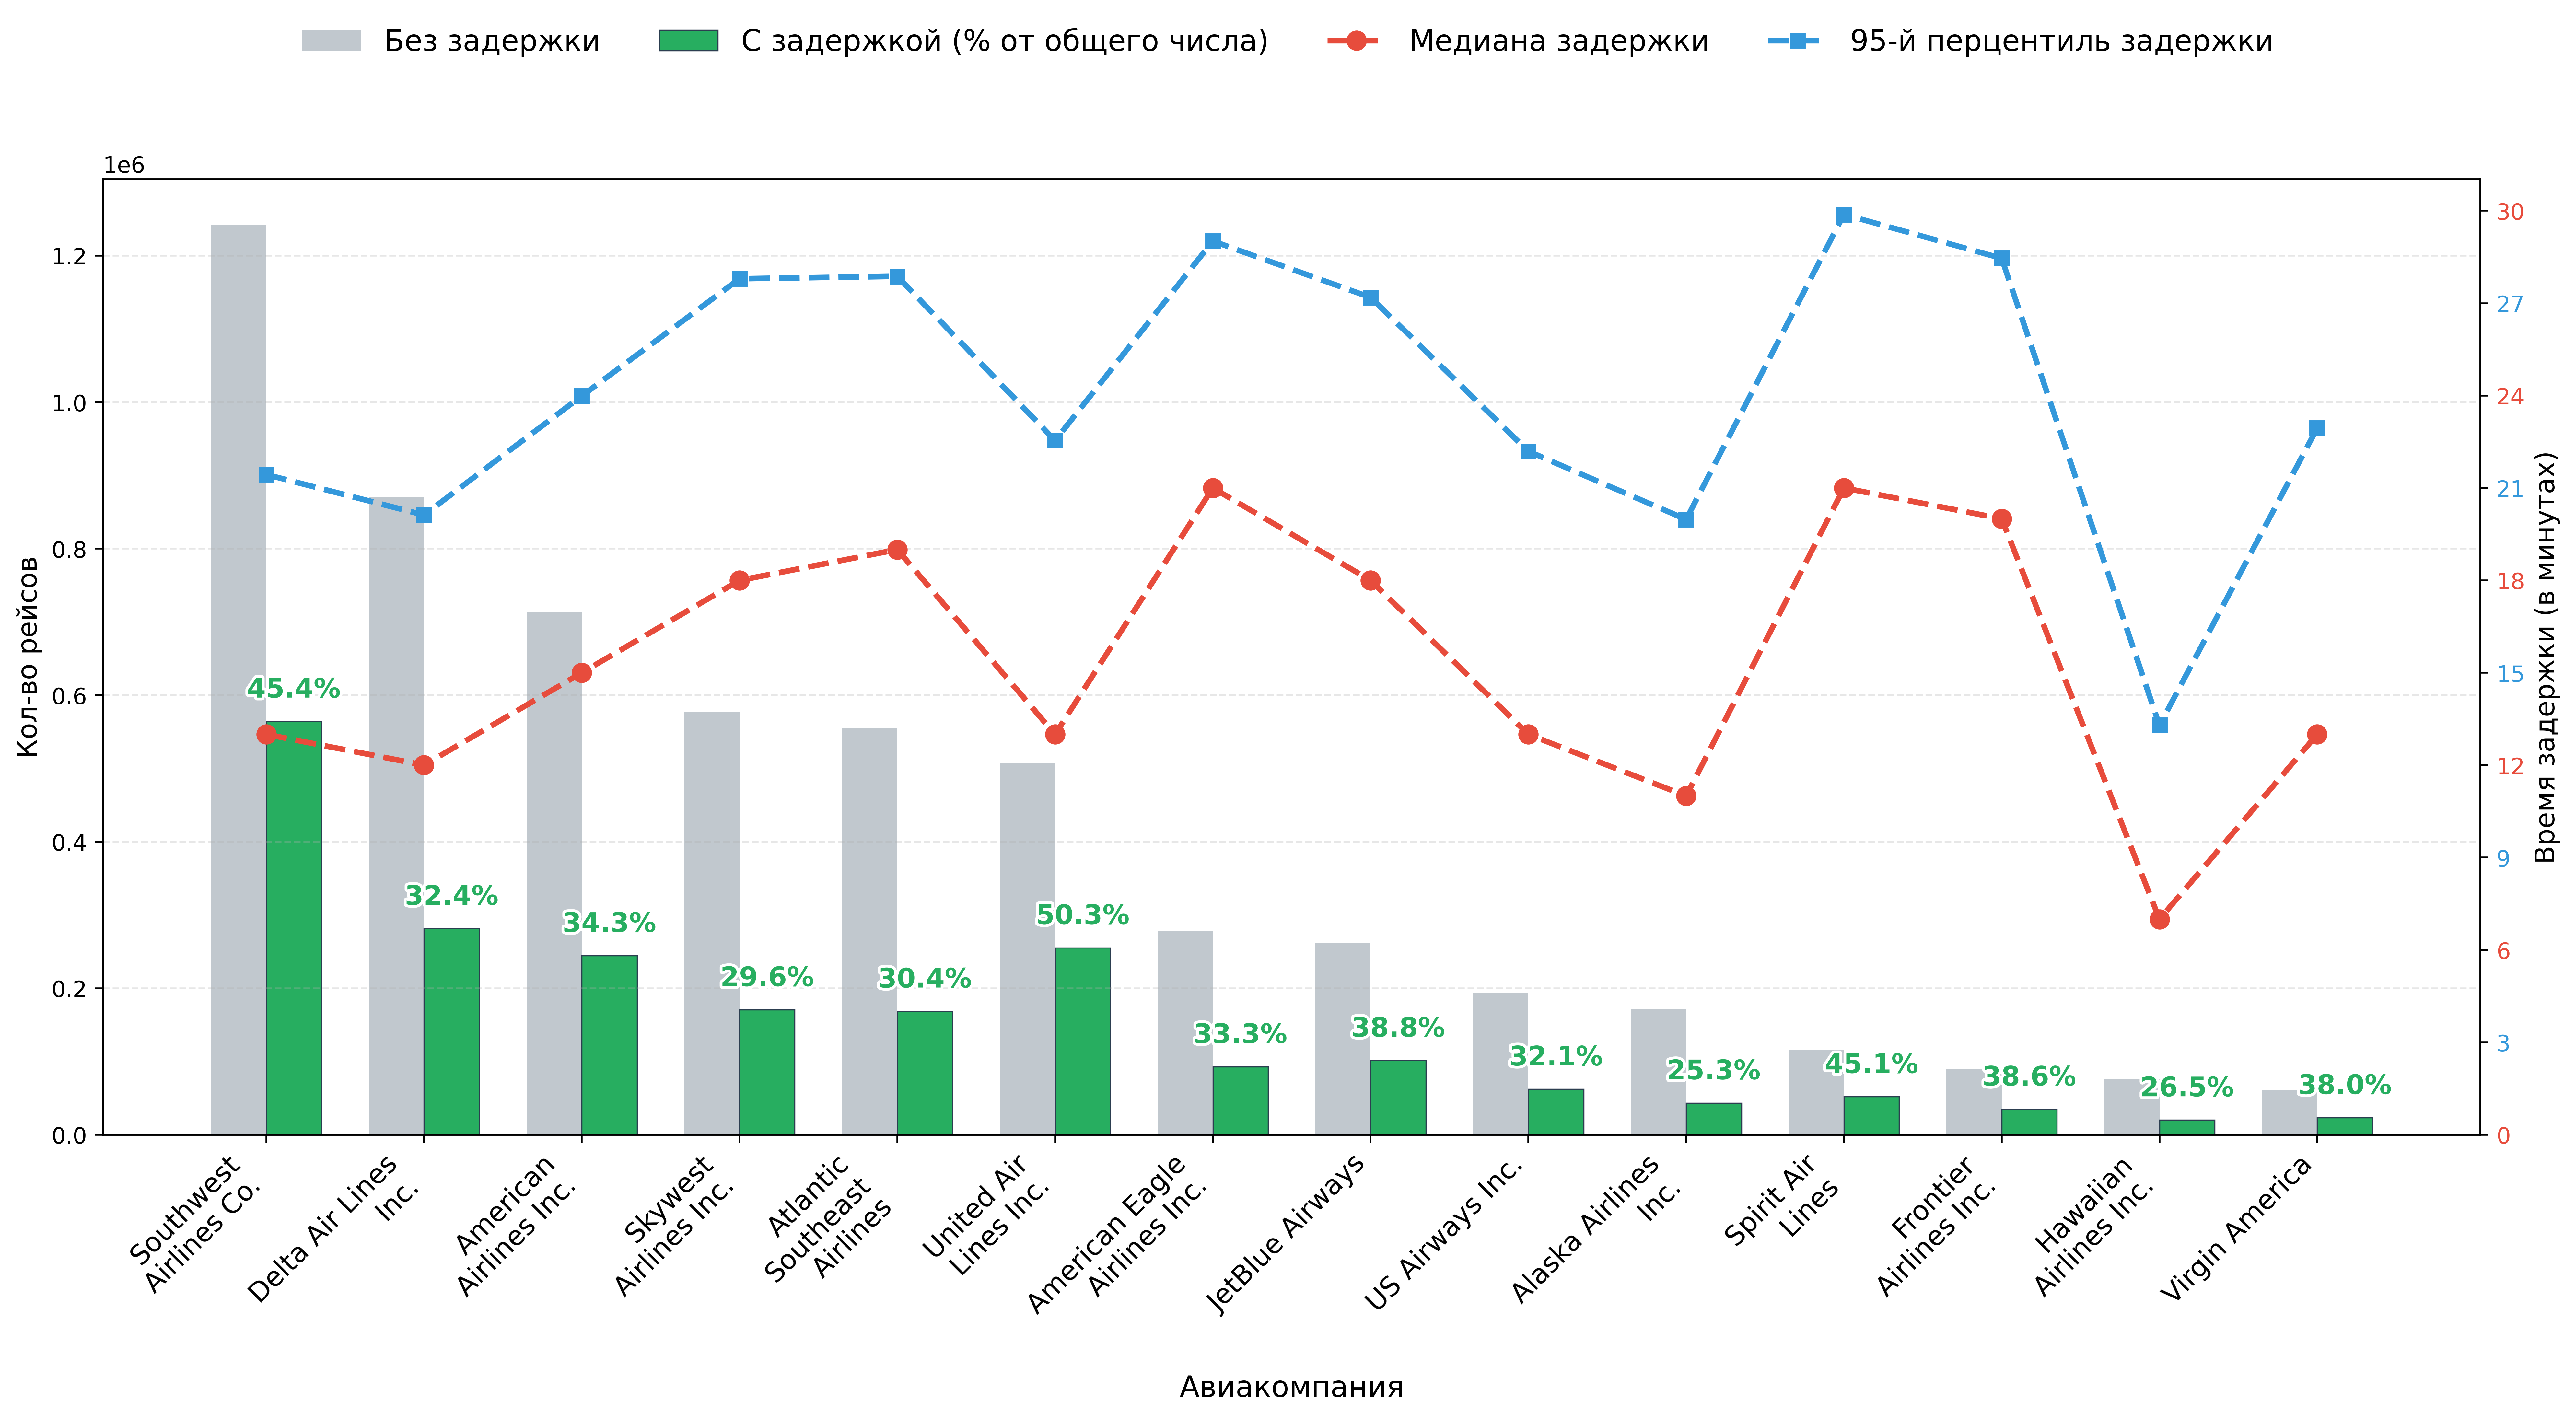

In [18]:
flights_with_airlines = pd.merge(
    flights_df,
    airlines_df,
    left_on='AIRLINE',
    right_on='IATA_CODE',
    how='left',
    suffixes=('', '_NAME')
)

df = flights_with_airlines[flights_with_airlines['DEPARTURE_DELAY'] > 0].copy()
all_df = flights_with_airlines.copy()

total_flights_by_airline = (
    all_df.groupby('AIRLINE_NAME')['DEPARTURE_DELAY']
    .agg(['count'])
    .sort_values('count', ascending=False)
)

delay_by_airline = (
    df.groupby('AIRLINE_NAME')['DEPARTURE_DELAY']
    .agg(['count', 'median'])
    .reindex(total_flights_by_airline.index)
)

delay_by_airline['percent'] = (delay_by_airline['count'] / total_flights_by_airline['count'] * 100).round(1)

delay_by_airline['mean_no_outliers'] = (
    df[df['DEPARTURE_DELAY'] <= df['DEPARTURE_DELAY'].quantile(0.95)]
    .groupby('AIRLINE_NAME')['DEPARTURE_DELAY']
    .mean()
    .reindex(total_flights_by_airline.index)
)

fig, ax1 = plt.subplots(figsize=(16, 8), dpi=500)
x_pos = np.arange(len(total_flights_by_airline.index))
width = 0.35

ax1.bar(
    x_pos - width/2,
    total_flights_by_airline['count'],
    width,
    color='#34495e',
    alpha=0.3,
    label='Без задержки'
)

bars = ax1.bar(
    x_pos + width/2,
    delay_by_airline['count'],
    width,
    color='#27ae60',
    edgecolor='#2c3e50',
    linewidth=0.5,
    label='С задержкой (% от общего числа)'
)

for bar, pct in zip(bars, delay_by_airline['percent']):
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + total_flights_by_airline['count'].max()*0.02,
        f'{pct}%',
        ha='center',
        va='bottom',
        color='#27ae60',
        fontsize=12,
        fontweight='bold',
        path_effects=[
            patheffects.withStroke(
                linewidth=2.5,
                foreground='white'
            )
        ]
    )

ax1.set_xticks(x_pos)
ax1.set_xticklabels(
    total_flights_by_airline.index.str.wrap(15),
    rotation=45,
    ha='right',
    fontsize=12,
)

ax2 = ax1.twinx()
ax2.plot(
    x_pos,
    delay_by_airline['median'],
    color='#e74c3c',
    marker='o',
    markersize=8,
    linewidth=2.5,
    linestyle='--',
    label='Медиана задержки'
)
ax2.plot(
    x_pos,
    delay_by_airline['mean_no_outliers'],
    color='#3498db',
    marker='s',
    markersize=6,
    linewidth=2.5,
    linestyle='--',
    label='95-й перцентиль задержки'
)

ax1.set_xticks(x_pos)
ax2.set_yticks(np.arange(0, 33, 3))

labels = ax2.get_yticklabels()
for idx, label in enumerate(labels):
    if idx % 2 == 0:
        label.set_color('#e74c3c')
    else:
        label.set_color('#3498db')

ax1.set_xlabel('Авиакомпания', fontsize=13, labelpad=15)
ax1.set_ylabel('Кол-во рейсов', fontsize=12)
ax2.set_ylabel('Время задержки (в минутах)', fontsize=12)

ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
handles = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(
    handles, labels,
    loc='upper center',
    ncol=4,
    bbox_to_anchor=(0.5, 1.1),
    frameon=False,
    fontsize=13
)

plt.tight_layout()
plt.show()

Отсюда можно сделать такие **выводы**:
 * Большие проценты задержек вылета наблюдаются у *Southwest Airlines Co.*, *United Air Lines Inc.* и *Spirit Air Lines*. Если же *Southwest Airlines Co.* является лидером по общему числу рейсов, поэтому очень много факторов способны провоцировать задержки, то у других явно присутствуют какие-то проблемы. Поэтому рекомендуется провести детальный анализ этих авиакомпаний для выявления проблем.

### Анализ задержек вылета по аэропортам

In [19]:
airport_stats = (
    flights_df.groupby('ORIGIN_AIRPORT')
    .agg(
        delay_count=('DEPARTURE_DELAY', lambda x: (x > 0).sum()),
        total_flights=('DEPARTURE_DELAY', 'count'),
        avg_delay=('DEPARTURE_DELAY', 'mean')
    )
    .reset_index()
)

merged = pd.merge(
    airports_df,
    airport_stats,
    left_on='IATA_CODE',
    right_on='ORIGIN_AIRPORT',
    how='left'
).dropna(subset=['LATITUDE', 'LONGITUDE', 'delay_count'])

colormap = linear.plasma.scale(
    0, 
    merged['delay_count'].quantile(0.95)
)
colormap.caption = 'Количество задержек'

m = folium.Map(
    location=[37.0902, -95.7129],
    zoom_start=4,
    tiles='CartoDB dark_matter',
    control_scale=True
)

def create_circle_marker(row):
    radius = 8 + 35 * (row['delay_count'] / merged['delay_count'].max())
    
    return folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=radius,
        color='black',
        fill=True,
        fill_color=colormap(row['delay_count']),
        fill_opacity=0.8,
        weight=1.5,
        opacity=0.8
    )

for idx, row in merged.iterrows():
    popup_html = f"""
    <div style='font-family: Arial; font-size: 14px'>
        <b style='color:{colormap(row['delay_count'])};'>{row['AIRPORT']}</b><br>
        <hr style='margin:5px 0'>
        Город: {row['CITY']}<br>
        Всего рейсов: <b>{row['total_flights']}</b><br>
        Задержано: <b style='color:red'>{row['delay_count']}</b><br>
        Средняя задержка: <b>{row['avg_delay']:.1f} мин</b>
    </div>
    """
    
    marker = create_circle_marker(row)
    marker.add_child(folium.Popup(popup_html, max_width=300))
    marker.add_to(m)

display(m)

Отсюда можно сделать такие **выводы**:
 * Самые загруженные аэропорты находятся в Атланте, Денвере, Чикаго, Далласе, Лос-Анджелесе и Нью-Йорке (в совокупности для 3 аэропортов). Эти аэропорты испытывают большие проблемы с задержками, которые могут быть связаны с недостаточной инфраструктурой или нехваткой ресурсов. Для таких аэропортов важны меры по оптимизации расписания, улучшению логистики и расширению инфраструктуры.